In [5]:
# import and set options
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import os
from collections import Counter
import utils

## Method Concensus

Cancer driver genes through the pattern of somatic mutations may show several signals of positive selection. It therefore is likely that several computational methods may find a gene as significant. Further, there is a correlation between the number of methods which agree a gene is a significant cancer driver gene and the likelihood a gene is found in the cancer gene census. With this observation, the fraction of predicted driver genes by each method which agrees with additional methods serves as a proxy for positive predictive value.

### Method overlap functions


In [29]:
def gene_overlap_count(cts, num_methods):
    """Count the number of methods that agree on each significant gene."""
    # now count the number of overlaps
    ovlp_genes = {}
    for nmeth in range(1, num_methods+1):
        mygenes = [x for x in cts if cts[x]==nmeth]
        ovlp_genes[nmeth] = mygenes

    # format the results to a dataframe
    max_genes = max(map(len, ovlp_genes.values()))
    for i in range(1, num_methods+1):
        list_len = len(ovlp_genes[i])
        ovlp_genes[i] = ovlp_genes[i] + [None]*(max_genes-list_len)
    overlap_df = pd.DataFrame(ovlp_genes)

    return overlap_df


def method_overlap_count(signif_genes, gene_counts):
    """Calculate the ammount of overlap with other methods."""
    output_list = []
    for method in signif_genes:
        # list of num ovlps
        method_cts = [gene_counts[g]-1 for g in signif_genes[method]]

        # get overlap counts
        num_uniq = len([x for x in method_cts if x==0])
        num_one = len([x for x in method_cts if x==1])
        num_two = len([x for x in method_cts if x==2])
        num_three = len([x for x in method_cts if x>=3])
        num_total = len(method_cts)

        # append result
        tmp_list = [method, num_total, num_uniq, num_one, num_two, num_three]
        output_list.append(tmp_list)

    # format into dataframe
    #header_names = ['Method', 'Total', 'unique', '1', '2', '>=3']
    header_names = ['Method', 'Total', 'predicted by 1 method', 'two methods',
                    'three methods', 'at least four methods']
    output_df = pd.DataFrame(output_list, columns=header_names)

    return output_df

### Load data

In [32]:
# load config file
config = utils.load_config('config.yaml')

# make output directory
if not os.path.exists('output'): os.mkdir('output')

# get the significant genes for each method
signif_dict = utils.fetch_significant_genes('example_data/pancan',  # data directory
                                            .1,  # q-value threshold
                                            config)
num_methods = len(signif_dict)

# eliminate any excluded methods.
# in this case, this is OncodriveFM as
# the latest version OncodriveFML is already included
if utils.is_valid_config(config, 'exclude', 'method_overlap'):
    exclude_methods = config['exclude']['method_overlap']
    meth_list = list(signif_dict.keys())
    for meth in meth_list:
        if meth in exclude_methods:
            del signif_dict[meth]

### Calculate overlap

In [33]:
# count how many time each gene is significant
gene_cts = Counter([g for method in signif_dict for g in signif_dict[method]])
gene_overlap_df = gene_overlap_count(gene_cts, num_methods)
gene_overlap_df.to_csv('output/gene_overlap_counts.txt', sep='\t', index=False)

# calculate the number of overlaps for each method
method_ovlp_df = method_overlap_count(signif_dict, gene_cts)
method_ovlp_df

,Method,Total,predicted by 1 method,two methods,three methods,at least four methods
0,ActiveDriver,417,316,69,9,23
1,OncodriveClust,586,389,127,21,49
2,TUSON,243,35,64,43,101
3,OncodriveFML,679,402,141,42,94
4,MuSiC,1975,1582,257,41,95
5,MutsigCV,158,52,28,13,65
6,2020+,208,40,38,32,98


### Plot results

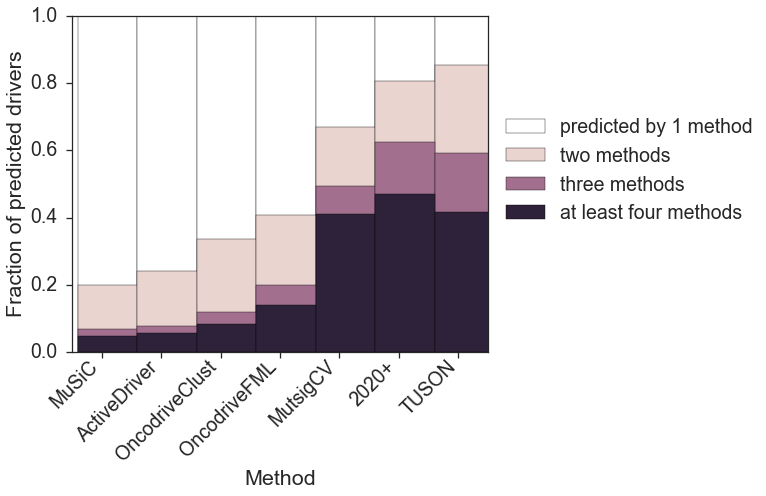

In [34]:
def plot_method_overlap(overlap_df):
    """Plot method overlap"""
    # calculate the fractions
    overlap_df['predicted by 1 method'] = 1.0
    mycols = ['two methods', 'three methods', 'at least four methods']
    overlap_df.loc[:, mycols] = overlap_df.loc[:, mycols].astype(float).div(overlap_df['Total'], axis=0)
    overlap_df['three methods'] = overlap_df['three methods'] + overlap_df['at least four methods']
    overlap_df['two methods'] = overlap_df['two methods'] + overlap_df['three methods']

    # order methods in increasing order
    mymethods = overlap_df.sort_values('two methods')['Method'].tolist()

    colors = ['white'] + sns.cubehelix_palette(3)[:3]
    for i, col in enumerate(['predicted by 1 method', 
                             'two methods', 'three methods', 'at least four methods']):
        with sns.axes_style('ticks', rc={'xtick.major.pad':-1.0}), sns.plotting_context('talk', font_scale=1.5):
            sns.barplot('Method', col, data=overlap_df,
                        color=colors[i], label=col, order=mymethods,)

            # Finishing touches
            lgd = plt.legend(bbox_to_anchor=(1, .75), loc='upper left',
                             ncol=1,)
            plt.ylim((0, 1))
            plt.ylabel('Fraction of predicted drivers')
            plt.gca().set_xticklabels(mymethods, rotation=45, ha='right')
            fig = plt.gcf()
            fig.set_size_inches(7, 7)

            # set bar width to 1
            for container in plt.gca().containers:
                plt.setp(container, width=1)
            # remove extra ticks
            plt.gca().get_xaxis().tick_bottom()
            plt.gca().get_yaxis().tick_left()

            # change tick padding
            plt.gca().tick_params(axis='x', which='major', pad=0)

    plt.tight_layout()

plot_method_overlap(method_ovlp_df.copy())